In [22]:
import random
import sys
from typing import Callable, List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import time

In [23]:
def feature_function(X: np.ndarray, y: int):
    # middle = X.shape[1]
    middle = X.shape[1] + 1
    feature = np.zeros(shape=(X.shape[0], 2*X.shape[1] + 2))
    # feature = np.zeros(shape=(X.shape[0], 2*X.shape[1]))
    if y == 1:
      feature[:, :middle] = np.c_[np.ones(X.shape[0]),X]
      # feature[:, :middle] = X
    else:
      feature[:, middle:] = np.c_[np.ones(X.shape[0]),X]
      # feature[:, middle:] = X
    return feature

def negative_log_likelihood(theta: np.ndarray, feat_pos: np.ndarray, feat_neg: np.ndarray, y: np.ndarray):
    theta_feat_pos = np.dot(feat_pos, theta)
    theta_feat_neg = np.dot(feat_neg, theta)
    
    res = 0
    res -= (np.sum(theta_feat_pos[y==1], axis=0) + np.sum(theta_feat_neg[y==0], axis=0))
    res += np.sum(np.log(np.exp(theta_feat_pos) + np.exp(theta_feat_neg)) , axis = 0)
    return res

def gradient_negative_log_likelihood(theta: np.ndarray, feat_pos: np.ndarray, feat_neg: np.ndarray, y: np.ndarray):
    delta_theta = np.zeros(theta.shape)
    exp_pos = np.exp(np.dot(feat_pos, theta))
    exp_neg = np.exp(np.dot(feat_neg, theta))
    delta_theta -= (np.sum(feat_pos[y==1], axis = 0) + np.sum(feat_neg[y==0], axis = 0))
    delta_theta += np.sum(( (feat_pos.T * (exp_pos/(exp_pos + exp_neg))).T + (feat_neg.T * (exp_neg/(exp_pos + exp_neg))).T ), axis = 0)
    return delta_theta 


In [24]:
class LogLinearModel:
    def __init__(
        self,
        feature_function: Callable,
        learning_rate: float,
        iterations: int,
        loss: Callable,
        gradient_loss: Callable,
        verbose: bool,
    ):
        """
        Parameters
        ---
        feature_function : Callable
            Feature function mapping from X x Y -> R^m
        learning_rate : float
            Learning rate parameter eta for gradient descent
        iterations : int
            Number of iterations to run gradient descent for during `fit`
        loss : Callable
            Loss function to be used by this LogLinearModel instance as
            a function of the parameters and the data X and y
        gradient_loss : Callable
            Closed form gradient of the `loss` function used for gradient descent as
            a function of the parameters and the data X and y
        verbose : bool
            Verbosity level of the class. If verbose == True,
            the class will print updates about the gradient
            descent steps during `fit`

        """
        # TODO
        self.feature = feature_function
        self.lr = learning_rate
        self.iter = iterations
        self.loss = loss
        self.grad_loss = gradient_loss
        self.verbose = verbose
        self.theta = None
        self.feat_pos = None
        self.feat_neg = None
        self.max_change = None

    def gradient_descent(self, X: np.ndarray, y: np.ndarray):
        """Performs one gradient descent step, and update parameters inplace.

        Parameters
        ---
        X : np.ndarray
            Data matrix
        y : np.ndarray
            Binary target values

        Returns
        ---
        None

        """
        # TODO
        grad_vector = self.grad_loss(self.theta,self.feat_pos,self.feat_neg,y)
        delta_theta = self.lr * grad_vector
        self.max_change = np.max(delta_theta)
        self.theta -= delta_theta
        

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Fits LogLinearModel class using gradient descent.

        Parameters
        ---
        X : np.ndarray
            Input data matrix
        y : np.ndarray
            Binary target values

        Returns
        ---
        None

        """
        # TODO
        self.feat_pos = self.feature(X, 1)
        self.feat_neg = self.feature(X, 0)
        self.theta = np.random.rand(self.feat_pos.shape[1]).astype('float64')
        for epoch in range(self.iter):
          loss = self.loss(self.theta, self.feat_pos, self.feat_neg, y)
          self.gradient_descent(X, y)
          loss_prime = self.loss(self.theta, self.feat_pos, self.feat_neg, y)

          if self.verbose:
            delta_loss = loss_prime - loss
            print("Iteration: %02d/%d | Loss Change: %03.5f | Largest Absolute Change of Parameters: %.5f"%(epoch, self.iter, delta_loss, self.max_change))
            
          


    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predicts binary target labels for input data `X`.

        Parameters
        ---
        X : np.ndarray
            Input data matrix

        Returns
        ---
        np.ndarray
            Predicted binary target labels

        """
        # TODO
        feat_pos = self.feature(X, 1)
        feat_neg = self.feature(X, 0)

        exp_pos = np.exp(np.dot(feat_pos, self.theta))
        exp_neg = np.exp(np.dot(feat_neg, self.theta))
        y = (exp_pos > exp_neg).astype('int64')
        return y
        

In [25]:
# Set seeds to ensure reproducibility
np.random.seed(42)
random.seed(42)

lr = LogisticRegression()
learning_rate = 0.0001

llm = LogLinearModel(
    feature_function=feature_function,  # TODO
    learning_rate=learning_rate,  # Make sure that the model converges
                                  # with your chosen learning rate
    iterations=100,
    loss=negative_log_likelihood,  # TODO
    gradient_loss=gradient_negative_log_likelihood,  # TODO
    verbose=True
)

In [26]:
llm_training_time_list = []
llm_prediction_time_list = []
llm_in_sample_accuracy_list = []
llm_out_sample_accuracy_list= []
lr_training_time_list = []
lr_prediction_time_list = []
lr_in_sample_accuracy_list = []
lr_out_sample_accuracy_list= []

In [27]:
# First dataset
# Fit both `lr` and your `llm` on this dataset and compare
# the aspects described in the assignment PDF
X, y = make_classification(
    n_samples=100, random_state=42, n_informative=20, n_features=20, n_redundant=0
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

start_time = time.time()
llm.fit(X_train,y_train)
time_used = time.time()-start_time
llm_training_time_list.append(time_used)

start_time = time.time()
lr.fit(X_train,y_train)
time_used = time.time()-start_time
lr_training_time_list.append(time_used)

start_time = time.time()
y_train_pred_llm = llm.predict(X_train)
time_used = time.time()-start_time
llm_prediction_time_list.append(time_used)
llm_in_sample_accuracy_list.append(accuracy_score(y_train, y_train_pred_llm))

start_time = time.time()
y_train_pred_lr = lr.predict(X_train)
time_used = time.time()-start_time
lr_prediction_time_list.append(time_used)
lr_in_sample_accuracy_list.append(accuracy_score(y_train, y_train_pred_lr))

y_test_pred_llm = llm.predict(X_test)
llm_out_sample_accuracy_list.append(accuracy_score(y_test, y_test_pred_llm))

y_test_pred_lr = lr.predict(X_test)
lr_out_sample_accuracy_list.append(accuracy_score(y_test, y_test_pred_lr))


Iteration: 00/100 | Loss Change: -4.37374 | Largest Absolute Change of Parameters: 0.00562
Iteration: 01/100 | Loss Change: -4.32273 | Largest Absolute Change of Parameters: 0.00562
Iteration: 02/100 | Loss Change: -4.27019 | Largest Absolute Change of Parameters: 0.00561
Iteration: 03/100 | Loss Change: -4.21617 | Largest Absolute Change of Parameters: 0.00561
Iteration: 04/100 | Loss Change: -4.16075 | Largest Absolute Change of Parameters: 0.00560
Iteration: 05/100 | Loss Change: -4.10398 | Largest Absolute Change of Parameters: 0.00559
Iteration: 06/100 | Loss Change: -4.04592 | Largest Absolute Change of Parameters: 0.00558
Iteration: 07/100 | Loss Change: -3.98661 | Largest Absolute Change of Parameters: 0.00557
Iteration: 08/100 | Loss Change: -3.92610 | Largest Absolute Change of Parameters: 0.00555
Iteration: 09/100 | Loss Change: -3.86440 | Largest Absolute Change of Parameters: 0.00553
Iteration: 10/100 | Loss Change: -3.80151 | Largest Absolute Change of Parameters: 0.00551

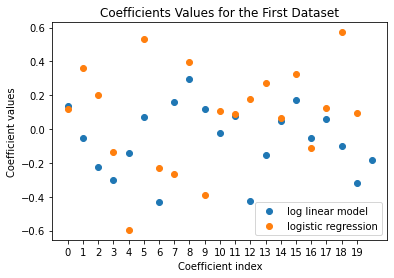

In [28]:
middle = int(llm.theta.shape[0]/2)
plt.scatter(list(range(middle)), llm.theta[middle:] - llm.theta[:middle], label = "log linear model")
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient values')
plt.scatter(list(range(lr.coef_.shape[1])), lr.coef_.T,label = "logistic regression")
plt.legend()
plt.title('Coefficients Values for the First Dataset')
plt.xticks(list(range(lr.coef_.shape[1])))
plt.show()

In [29]:
# Second dataset
# Fit both `lr` and your `llm` on this dataset and compare
# the aspects described in the assignment PDF
X, y = make_classification(
    n_samples=1000,
    random_state=42,
    n_informative=20,
    n_redundant=10,
    n_features=35,
    n_repeated=5,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
start_time = time.time()
llm.fit(X_train,y_train)
time_used = time.time()-start_time
llm_training_time_list.append(time_used)

start_time = time.time()
lr.fit(X_train,y_train)
time_used = time.time()-start_time
lr_training_time_list.append(time_used)

start_time = time.time()
y_train_pred_llm = llm.predict(X_train)
time_used = time.time()-start_time
llm_prediction_time_list.append(time_used)
llm_in_sample_accuracy_list.append(accuracy_score(y_train, y_train_pred_llm))

start_time = time.time()
y_train_pred_lr = lr.predict(X_train)
time_used = time.time()-start_time
lr_prediction_time_list.append(time_used)
lr_in_sample_accuracy_list.append(accuracy_score(y_train, y_train_pred_lr))

y_test_pred_llm = llm.predict(X_test)
llm_out_sample_accuracy_list.append(accuracy_score(y_test, y_test_pred_llm))

y_test_pred_lr = lr.predict(X_test)
lr_out_sample_accuracy_list.append(accuracy_score(y_test, y_test_pred_lr))

Iteration: 00/100 | Loss Change: -708.59249 | Largest Absolute Change of Parameters: 0.12184
Iteration: 01/100 | Loss Change: -354.79549 | Largest Absolute Change of Parameters: 0.07607
Iteration: 02/100 | Loss Change: -205.11454 | Largest Absolute Change of Parameters: 0.04049
Iteration: 03/100 | Loss Change: -116.12858 | Largest Absolute Change of Parameters: 0.03720
Iteration: 04/100 | Loss Change: -44.67663 | Largest Absolute Change of Parameters: 0.03392
Iteration: 05/100 | Loss Change: 42.94855 | Largest Absolute Change of Parameters: 0.05172
Iteration: 06/100 | Loss Change: 343.91911 | Largest Absolute Change of Parameters: 0.11514
Iteration: 07/100 | Loss Change: -488.57477 | Largest Absolute Change of Parameters: 0.10536
Iteration: 08/100 | Loss Change: 109.53359 | Largest Absolute Change of Parameters: 0.06880
Iteration: 09/100 | Loss Change: 22.28365 | Largest Absolute Change of Parameters: 0.09020
Iteration: 10/100 | Loss Change: 429.01550 | Largest Absolute Change of Param

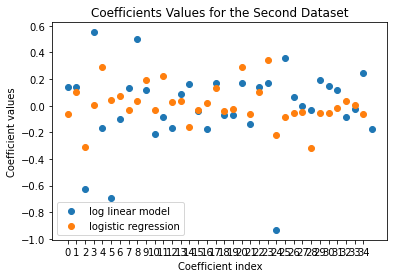

In [30]:
middle = int(llm.theta.shape[0]/2)
plt.scatter(list(range(middle)), llm.theta[middle:] - llm.theta[:middle], label = "log linear model")
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient values')
plt.scatter(list(range(lr.coef_.shape[1])), lr.coef_.T,label = "logistic regression")
plt.legend()
plt.title('Coefficients Values for the Second Dataset')
plt.xticks(list(range(lr.coef_.shape[1])))
plt.show()

In [31]:
# Third dataset
# Fit both `lr` and your `llm` on this dataset and compare
# the aspects described in the assignment PDF
X, y = make_classification(
    n_samples=10000, random_state=42, n_informative=2, n_repeated=5
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
start_time = time.time()
llm.fit(X_train,y_train)
time_used = time.time()-start_time
llm_training_time_list.append(time_used)

start_time = time.time()
lr.fit(X_train,y_train)
time_used = time.time()-start_time
lr_training_time_list.append(time_used)

start_time = time.time()
y_train_pred_llm = llm.predict(X_train)
time_used = time.time()-start_time
llm_prediction_time_list.append(time_used)
llm_in_sample_accuracy_list.append(accuracy_score(y_train, y_train_pred_llm))

start_time = time.time()
y_train_pred_lr = lr.predict(X_train)
time_used = time.time()-start_time
lr_prediction_time_list.append(time_used)
lr_in_sample_accuracy_list.append(accuracy_score(y_train, y_train_pred_lr))

y_test_pred_llm = llm.predict(X_test)
llm_out_sample_accuracy_list.append(accuracy_score(y_test, y_test_pred_llm))

y_test_pred_lr = lr.predict(X_test)
lr_out_sample_accuracy_list.append(accuracy_score(y_test, y_test_pred_lr))

Iteration: 00/100 | Loss Change: -9102.93612 | Largest Absolute Change of Parameters: 0.61743
Iteration: 01/100 | Loss Change: -557.52805 | Largest Absolute Change of Parameters: 0.08447
Iteration: 02/100 | Loss Change: -451.49418 | Largest Absolute Change of Parameters: 0.07184
Iteration: 03/100 | Loss Change: -344.33948 | Largest Absolute Change of Parameters: 0.05856
Iteration: 04/100 | Loss Change: -243.61649 | Largest Absolute Change of Parameters: 0.04542
Iteration: 05/100 | Loss Change: -159.39767 | Largest Absolute Change of Parameters: 0.03520
Iteration: 06/100 | Loss Change: -100.44191 | Largest Absolute Change of Parameters: 0.02500
Iteration: 07/100 | Loss Change: -66.24626 | Largest Absolute Change of Parameters: 0.02480
Iteration: 08/100 | Loss Change: -48.07622 | Largest Absolute Change of Parameters: 0.02384
Iteration: 09/100 | Loss Change: -37.39611 | Largest Absolute Change of Parameters: 0.02225
Iteration: 10/100 | Loss Change: -29.83973 | Largest Absolute Change of 

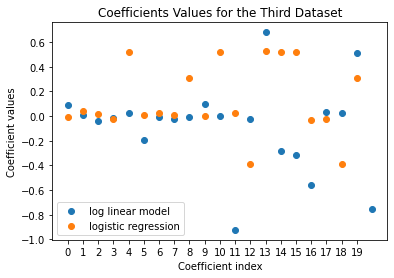

In [32]:
middle = int(llm.theta.shape[0]/2)
plt.scatter(list(range(middle)), llm.theta[middle:] - llm.theta[:middle], label = "log linear model")
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient values')
plt.scatter(list(range(lr.coef_.shape[1])), lr.coef_.T,label = "logistic regression")
plt.legend()
plt.title('Coefficients Values for the Third Dataset')
plt.xticks(list(range(lr.coef_.shape[1])))
plt.show()

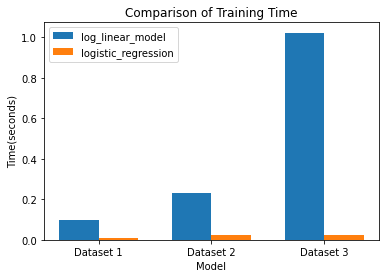

In [33]:
bar_width = 0.35
fig, ax = plt.subplots()
log_linear_model = ax.bar(np.arange(len(llm_training_time_list)), llm_training_time_list , bar_width, label="log_linear_model")
logistic_regression = ax.bar(np.arange(len(lr_training_time_list))+bar_width, lr_training_time_list,bar_width, label="logistic_regression")
ax.set_xlabel('Model')
ax.set_ylabel('Time(seconds)')
ax.set_title('Comparison of Training Time')
ax.set_xticks(np.arange(len(llm_training_time_list)) + bar_width / 2)
ax.set_xticklabels(["Dataset 1", "Dataset 2", "Dataset 3"])
ax.legend()
plt.show()

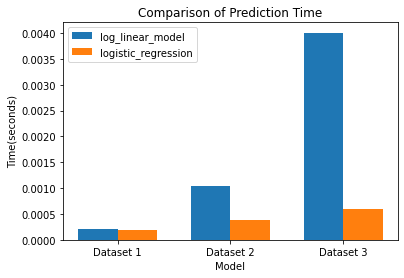

In [34]:
bar_width = 0.35
fig, ax = plt.subplots()
log_linear_model = ax.bar(np.arange(len(llm_training_time_list)), llm_prediction_time_list , bar_width, label="log_linear_model")
logistic_regression = ax.bar(np.arange(len(lr_training_time_list))+bar_width, lr_prediction_time_list,bar_width, label="logistic_regression")
ax.set_xlabel('Model')
ax.set_ylabel('Time(seconds)')
ax.set_title('Comparison of Prediction Time')
ax.set_xticks(np.arange(len(llm_training_time_list)) + bar_width / 2)
ax.set_xticklabels(["Dataset 1", "Dataset 2", "Dataset 3"])
ax.legend()
plt.show()

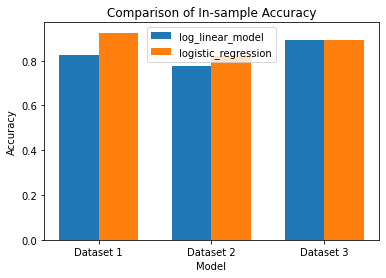

In [35]:
bar_width = 0.35
fig, ax = plt.subplots()
log_linear_model = ax.bar(np.arange(len(llm_in_sample_accuracy_list)), llm_in_sample_accuracy_list , bar_width, label="log_linear_model")
logistic_regression = ax.bar(np.arange(len(lr_in_sample_accuracy_list))+bar_width, lr_in_sample_accuracy_list,bar_width, label="logistic_regression")
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of In-sample Accuracy')
ax.set_xticks(np.arange(len(llm_training_time_list)) + bar_width / 2)
ax.set_xticklabels(["Dataset 1", "Dataset 2", "Dataset 3"])
ax.legend()
plt.show()

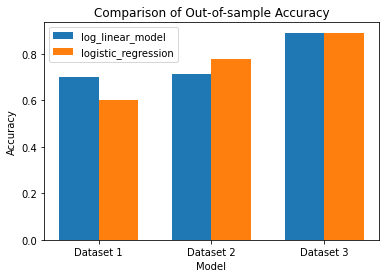

In [36]:
bar_width = 0.35
fig, ax = plt.subplots()
log_linear_model = ax.bar(np.arange(len(llm_out_sample_accuracy_list)), llm_out_sample_accuracy_list , bar_width, label="log_linear_model")
logistic_regression = ax.bar(np.arange(len(lr_out_sample_accuracy_list))+bar_width, lr_out_sample_accuracy_list,bar_width, label="logistic_regression")
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Out-of-sample Accuracy')
ax.set_xticks(np.arange(len(llm_training_time_list)) + bar_width / 2)
ax.set_xticklabels(["Dataset 1", "Dataset 2", "Dataset 3"])
ax.legend()
plt.show()